# Benchmark C1.2: Coupled problems - Water uptake by a static root system
by Daniel Leitner, Andrea Schnepf

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.interpolate import interp1d
import os
from van_genuchten import *

## Comparison of numerical solutions to reference solution

We compare different numerical codes by solving the benchmarking problems. In addition, we provide links to Jupyter Notebooks that describe the numerical implementation of a benchmark problem in a specific code should they be available in the sub-folder 'M3.2 Model descriptions'

### Result data format of C1.2




### Comparison to the analytical solution

We plot potential and actual transpiration

In [6]:
def sinusoidal(t): # to calculate potential transpiration
    return np.sin(2. * np.pi * np.array(t) - 0.5 * np.pi) + 1.

def plot_all(path):
    nrmse, names = [], []
    fig, ax = plt.subplots(2, 1, figsize=(14, 18))
    data = np.loadtxt(path +"reference.csv", delimiter=';')  
    t_a=data[0,:] 
    y_a=data[1,:] 
    cumy_a = integrate.cumtrapz(data[1,:],data[0,:],initial=0)
    ax[0].plot(t_a, 6.4*sinusoidal(t_a), 'k', label = "potential transpiration")
    ax[0].plot(t_a,y_a,'r*', label = "reference")
    ax[0].set_xlabel("time (day)")
    ax[0].set_ylabel("transpiration (cm$^3$ day$^{-1}$)")
    ax[1].plot(t_a,integrate.cumtrapz(y_a,t_a,initial=0),'r*', label = "reference")
    ax[1].set_xlabel("time (day)")
    ax[1].set_ylabel("cumulative uptake (cm$^3$)")
    cc = 0
    for dirname, dirnames, filenames in os.walk(path+'.'):
        filenames.sort(key=str.lower)
        for i,f in enumerate(filenames):
            try:
                if f != "reference.csv":                    
                    data = np.loadtxt(path+f,delimiter=';')  
                    t_ = data[0,data[0,:]<=3] 
                    a_ = data[1,data[0,:]<=3]
                    if f.endswith("_rhizo"): # rhizosphere model
                        cc -= 1 # last color
                        ax[0].plot(t_,a_, color = col[cc], label = f, linewidth = 1.5, alpha = 1, linestyle = "--")
                        ax[1].plot(t_,integrate.cumtrapz(a_,t_,initial=0), color = col[cc], label = f, linewidth = 1.5, alpha = 1, linestyle = "--")                  
                    else: # other sink term
                        ax[0].plot(t_,a_, color = col[cc], label = f, linewidth = 1.5, alpha = 1)                        
                        ax[1].plot(t_,integrate.cumtrapz(a_,t_,initial=0), color = col[cc], label = f, linewidth = 1.5, alpha = 1)                  
                    cc += 1
                    # for table
                    interp = interp1d(t_, integrate.cumtrapz(a_,t_,initial=0),  kind='linear', fill_value='extrapolate', bounds_error =False ) 
                    cumy_n = interp(t_a) 
                    nrmse.append(nRMSE(cumy_a, cumy_n))
                    names.append(f)
            except Exception as ex:
                print("Something went wrong with file "+f)    
                raise
    ax[0].legend(loc = 'upper right')
    ax[1].legend(loc = 'upper left')
    ax[1].set_ylim(0,15) # fix y axis
    return nrmse, names                

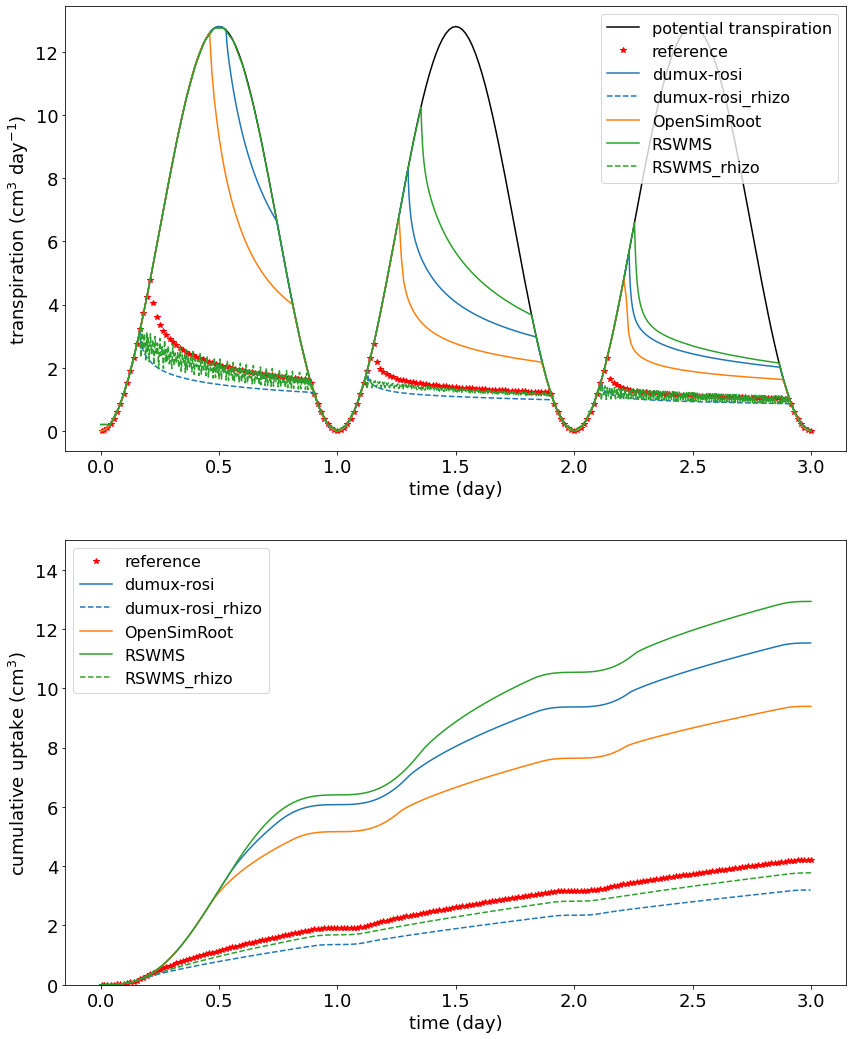

In [7]:
nrmsea, namea = plot_all("C1.2a Numerical results/")
plt.savefig('c12a_results.png', dpi=300, bbox_inches = "tight") 

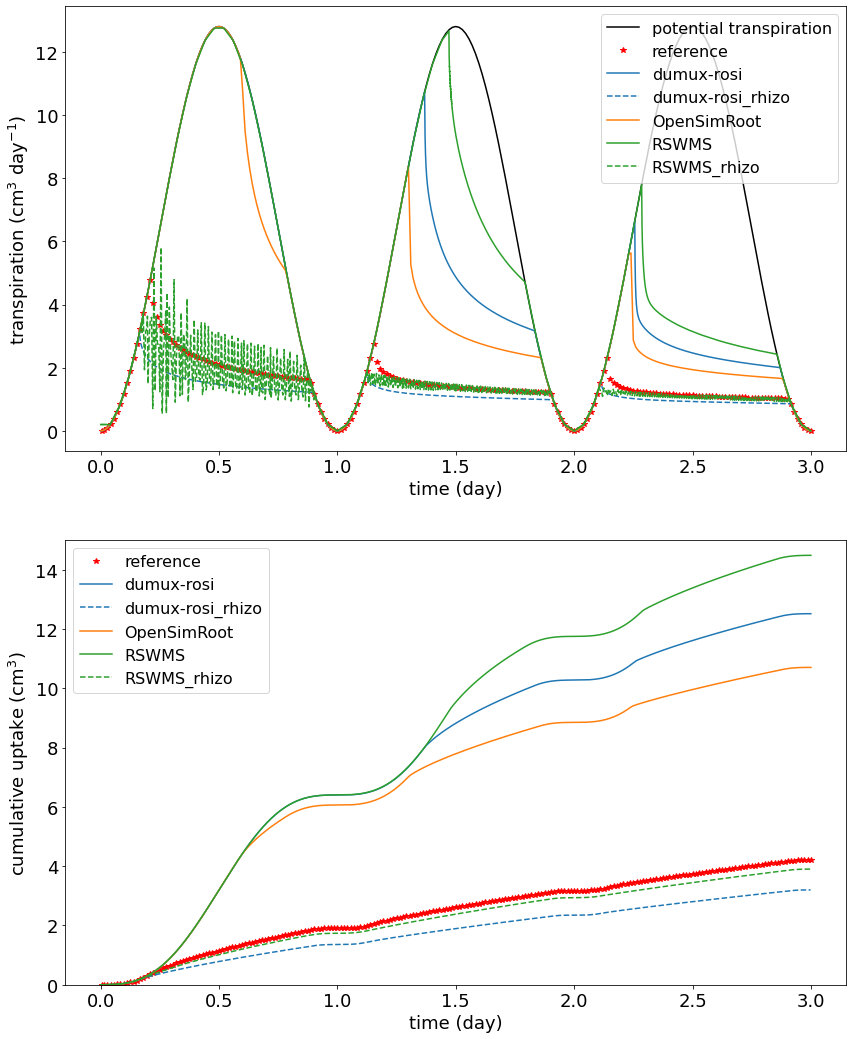

In [8]:
nrmseb, nameb = plot_all("C1.2b Numerical results/")
plt.savefig('c12b_results.png', dpi=300, bbox_inches = "tight") 

Additionally, we create a table using normalised RSME as an error measure (which were calculated in the cell above)

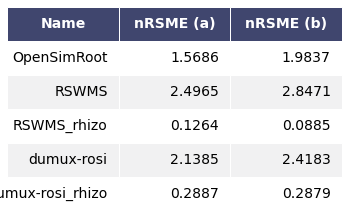

In [5]:
import pandas as pd 

data_ = np.array([namea, nrmsea, nrmseb]); #data_b = pandas.concat([data_, additional], axis=1)
data_ = np.array(data_.transpose())

df = pd.DataFrame(data_, columns = ['Name','nRSME (a)','nRSME (b)'] ) # Create the pandas DataFrame 
df['nRSME (a)'] = df['nRSME (a)'].astype(float)
df['nRSME (a)'] = df['nRSME (a)'].map('{:,.4f}'.format)
df['nRSME (b)'] = df['nRSME (b)'].astype(float)
df['nRSME (b)'] = df['nRSME (b)'].map('{:,.4f}'.format)
# print dataframe. 
df.style.set_table_styles(
[{'selector': 'tr:nth-of-type(odd)',
  'props': [('background', '#eee')]}, 
 {'selector': 'tr:nth-of-type(even)',
  'props': [('background', 'white')]},
 {'selector': 'th',
  'props': [('background', '#606060'), 
            ('color', 'white'),
            ('font-family', 'verdana')]},
 {'selector': 'td',
  'props': [('font-family', 'verdana')]},
]
).hide_index()

def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax.get_figure(), ax

fig,ax = render_mpl_table(df, header_columns=0, col_width=2.0)
fig.savefig("table_c12.png")


## References

Schnepf, A., Black, C.K., Couvreur, V., Delory, B.M., Doussan, C., Koch, A., Koch, T. et al. (2020) Call for participation: collaborative benchmarking of functional-structural root architecture models. The case of root water uptake. *Frontiers in Plant Science* 11, 316.